# A Replication of Models, Regimes, and Trend Following - Part 3

This notebook presents an **educational, step‑by‑step recreation** of [**JungleRock**](https://junglerock.com)'s *'Models, Regimes, and Trend Following - Part 3'*

> **Disclaimer:**  
> All methods and analyses applied here are taken and *interpreted* from JungleRock's white papers.  
> All credit for the methodologies used goes to JungleRock.  
> Results may not be 100% identical, but strive to be as close as possible.

This notebook goes through the following processes:  
1. Pull Fama–French Market − RF data.  
2. Check autocorrelation in daily series of returns and determine the lag with the best BIC for the model.  
3. Estimate a three‑state **Markov Switching Model** (MSM) of order 2 AR to classify *Bull*, *Bear* and *Chop* regimes.  
4. Compare returns and metrics in each regime and build oracle strategies.  

Feel free to run each cell and inspect intermediate functions, classes, outputs & plots.

## 1. Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from statsmodels.tsa.regime_switching.markov_autoregression \
    import MarkovAutoregression

In [3]:

notebook_path = os.path.abspath('')
repo_root = os.path.abspath(os.path.join(notebook_path, '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

if "google.colab" in sys.modules:
    if not os.path.exists("/content/models-regimes-trend"):
        !git clone https://github.com/internQuant/models-regimes-trend.git
    sys.path.insert(0, "/content/models-regimes-trend")

# Project‑specific helpers
from utils.data import *
from utils.misc import *
from utils.msm import *
from utils.plots import *
from utils.transforms import *

## 2. Load Data
Load the Fama-French daily returns snapshot from CSV and prepare the series.

In [4]:
csv_f = pd.read_csv(
    r'data/historical_snapshots/ff_data_daily_202410_snapshot.csv',
    skiprows=4,
    parse_dates=True
).dropna()

csv_f = csv_f.iloc[:, :2]
csv_f.columns = ['date', 'returns']
csv_f['date'] = pd.to_datetime(csv_f['date'])
csv_f = csv_f.set_index('date')['returns'].rename('Unconditional') / 100

# Subsample up to August 2024 and from 1943 onward
returns = csv_f.copy()[:'2024-08']
returns_subsample = returns['1943':].rename('Unconditional')

## 3. Autocorrelation Plot
Plot the autocorrelation function for the returns subsample.

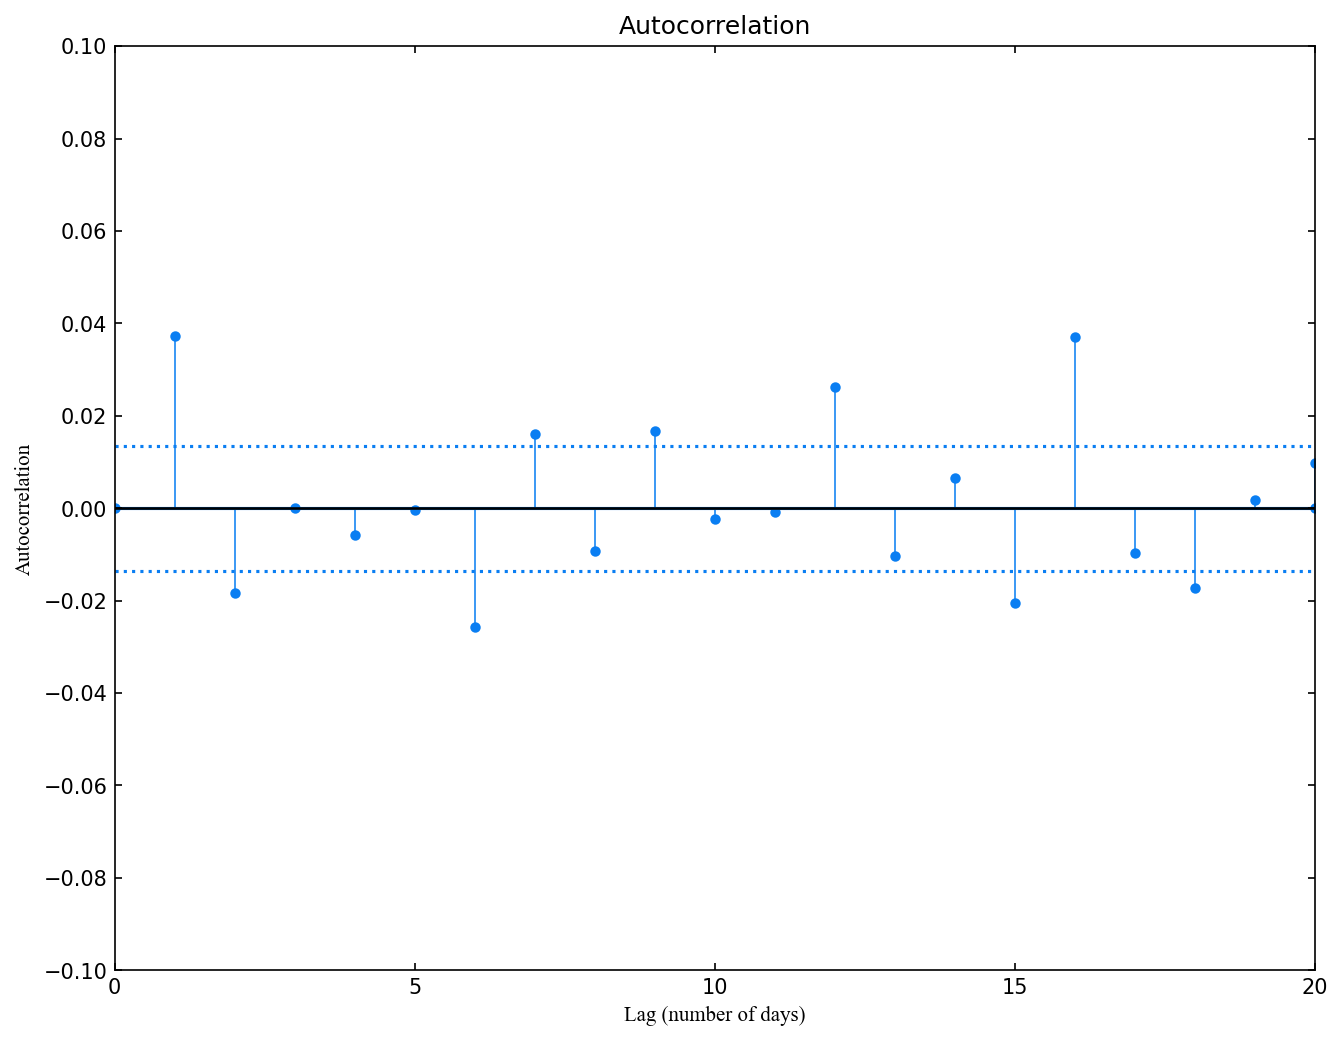

In [5]:
plot_acf_custom(returns_subsample)

## 4. Select Best AR Lag
Select the best autoregressive lag based on BIC and fit the AR model.
The coefficients obtained here are exactly the same as the ones showed in the paper

In [6]:
bic_series, best_lag = select_ar_lag(series=returns.values, max_lag=21)
print(f"Best AR lag by BIC: {best_lag}")

best_lag_fit = AutoReg(returns_subsample.values, lags=best_lag, trend='c').fit()
print(best_lag_fit.summary())

Selected lag: 2 (BIC=-160604.19)
Best AR lag by BIC: 2
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                20888
Model:                     AutoReg(2)   Log Likelihood               67722.243
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Sun, 08 Jun 2025   AIC                        -135436.486
Time:                        09:36:52   BIC                        -135404.698
Sample:                             2   HQIC                       -135426.107
                                20888                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   6.55e-05      5.020      0.000       0.000       0.000
y.L1           0.0381      0.007      5.502      0.000       0.025       0.0

## 5. Fit 3-Regime AR(2) MSM
Fit a Markov regime-switching model with 3 regimes, AR order 2, switching coefficients and variance.
The model obtained here is not the same as the one in paper, and this is probably due to how the MSM is implemented in statsmodels (the module being used here) and the papers implementation (looks like MATLAB is being used in throughout the paper)

In [7]:
msm_ar_model = MarkovAutoregression(
    returns_subsample,
    k_regimes=3,
    order=2,
    switching_ar=True,
    switching_trend=True,
    switching_variance=True
)
msm_fit = msm_ar_model.fit(maxiter=300)
print(msm_fit.summary())

c:\Users\rodri\miniconda3\envs\quant-challenge\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                         Markov Switching Model Results                         
Dep. Variable:            Unconditional   No. Observations:                20886
Model:             MarkovAutoregression   Log Likelihood               72483.735
Date:                  Sun, 08 Jun 2025   AIC                        -144931.471
Time:                          09:41:18   BIC                        -144788.428
Sample:                               0   HQIC                       -144884.769
                                - 20886                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -1.039      0.299      -0.000       0.000
sigma2      7.957e-05   2.91e-06    

## 6. Classify Regimes
Detect regimes and label them as bull, bear, and chop. 
Basically a sort by regime mean, bear is lowest, chop in the middle, bull is the highest

The model might output in different orders so this class helps to always order as bull -> bear -> chop

In [8]:
msm_classification = MSMParamClassifier(msm_fit.params)
print(msm_classification)

================ MSM Param Classifier(k=3) =================
Regime   |          μ |          σ | AR       1 | AR       2
------------------------------------------------------------
bull     |    0.00103 |    0.00453 |    0.17824 |   -0.08012
bear     |   -0.00189 |    0.02147 |   -0.06935 |   -0.02210
chop     |   -0.00013 |    0.00892 |    0.11006 |   -0.03081

Transition matrix P (bull, bear, chop):
  0.9669   0.0005   0.0327
  0.0000   0.9592   0.0408
  0.0351   0.0082   0.9567

regime_map: {'bull': 1, 'bear': 2, 'chop': 0}



## 7. Regime Summary
Build a summary table of regime parameter estimates, t-values, and p-values.
I'm not a fan of the p-value of the AR2 term in the bear regime, but i toyed around with different parameters for the estimation of the model and nothing really helped.
I decided to keep using the default parameters, only bumping maxiter to ensure MLE converges

In [9]:
reg_summ = build_3_regimes_summary(
    estimates=msm_fit.params,
    tvalues=msm_fit.tvalues,
    pvalues=msm_fit.pvalues
).round(4)
reg_summ

Estimate  t-statistic  p-value
Regime Parameter                                     
Bull   Constant          0.0010      15.5314   0.0000
       AR(1)             0.1782      14.2410   0.0000
       AR(2)            -0.0801      -6.6277   0.0000
       Std. Deviation    0.0045      28.9684   0.0000
Bear   Constant         -0.0019      -4.0515   0.0001
       AR(1)            -0.0693      -2.9425   0.0033
       AR(2)            -0.0221      -0.9290   0.3529
       Std. Deviation    0.0215      19.1766   0.0000
Chop   Constant         -0.0001      -1.0389   0.2989
       AR(1)             0.1101       9.2373   0.0000
       AR(2)            -0.0308      -2.6134   0.0090
       Std. Deviation    0.0089      27.3146   0.0000

## 8. Assign Regimes to Each Day
Assign the active regime each day based on highest smoothed probability. Pretty straightforward.

In [10]:
smoothed_probs = msm_fit.smoothed_marginal_probabilities
smoothed_probs = smoothed_probs[msm_classification.order]
smoothed_probs.columns = ['bull', 'bear', 'chop']
active_regime = smoothed_probs.idxmax(axis=1)
active_regime.head()

date
1943-01-05    bull
1943-01-06    bull
1943-01-07    bull
1943-01-08    bull
1943-01-09    bull
dtype: object

## 9. Oracle Strategies
Construct oracle long-short and long-only strategies based on true regimes.

In [11]:
bull_returns = returns_subsample.iloc[2:][active_regime == 'bull']
bear_returns = returns_subsample.iloc[2:][active_regime == 'bear']

regime_ret = pd.concat(
    [bull_returns, bear_returns], axis=1, keys=['Bull', 'Bear']
).reindex(active_regime.index).fillna(0)

ls = regime_ret['Bull'] - regime_ret['Bear']
lo = regime_ret['Bull']
strat_rets = pd.concat([
    returns_subsample, 
    ls.rename('Oracle Long-Short'), 
    lo.rename('Oracle Long-Only')
], axis=1).fillna(0)
strat_rets.head()

,Unconditional,Oracle Long-Short,Oracle Long-Only
date,,,
1943-01-02,0.0078,0.0000,0.0000
1943-01-04,0.0085,0.0000,0.0000
1943-01-05,-0.0036,-0.0036,-0.0036
1943-01-06,0.0004,0.0004,0.0004
1943-01-07,-0.0004,-0.0004,-0.0004


## 10. Plot Regime-Colored Returns and Cumulative Strategy Returns

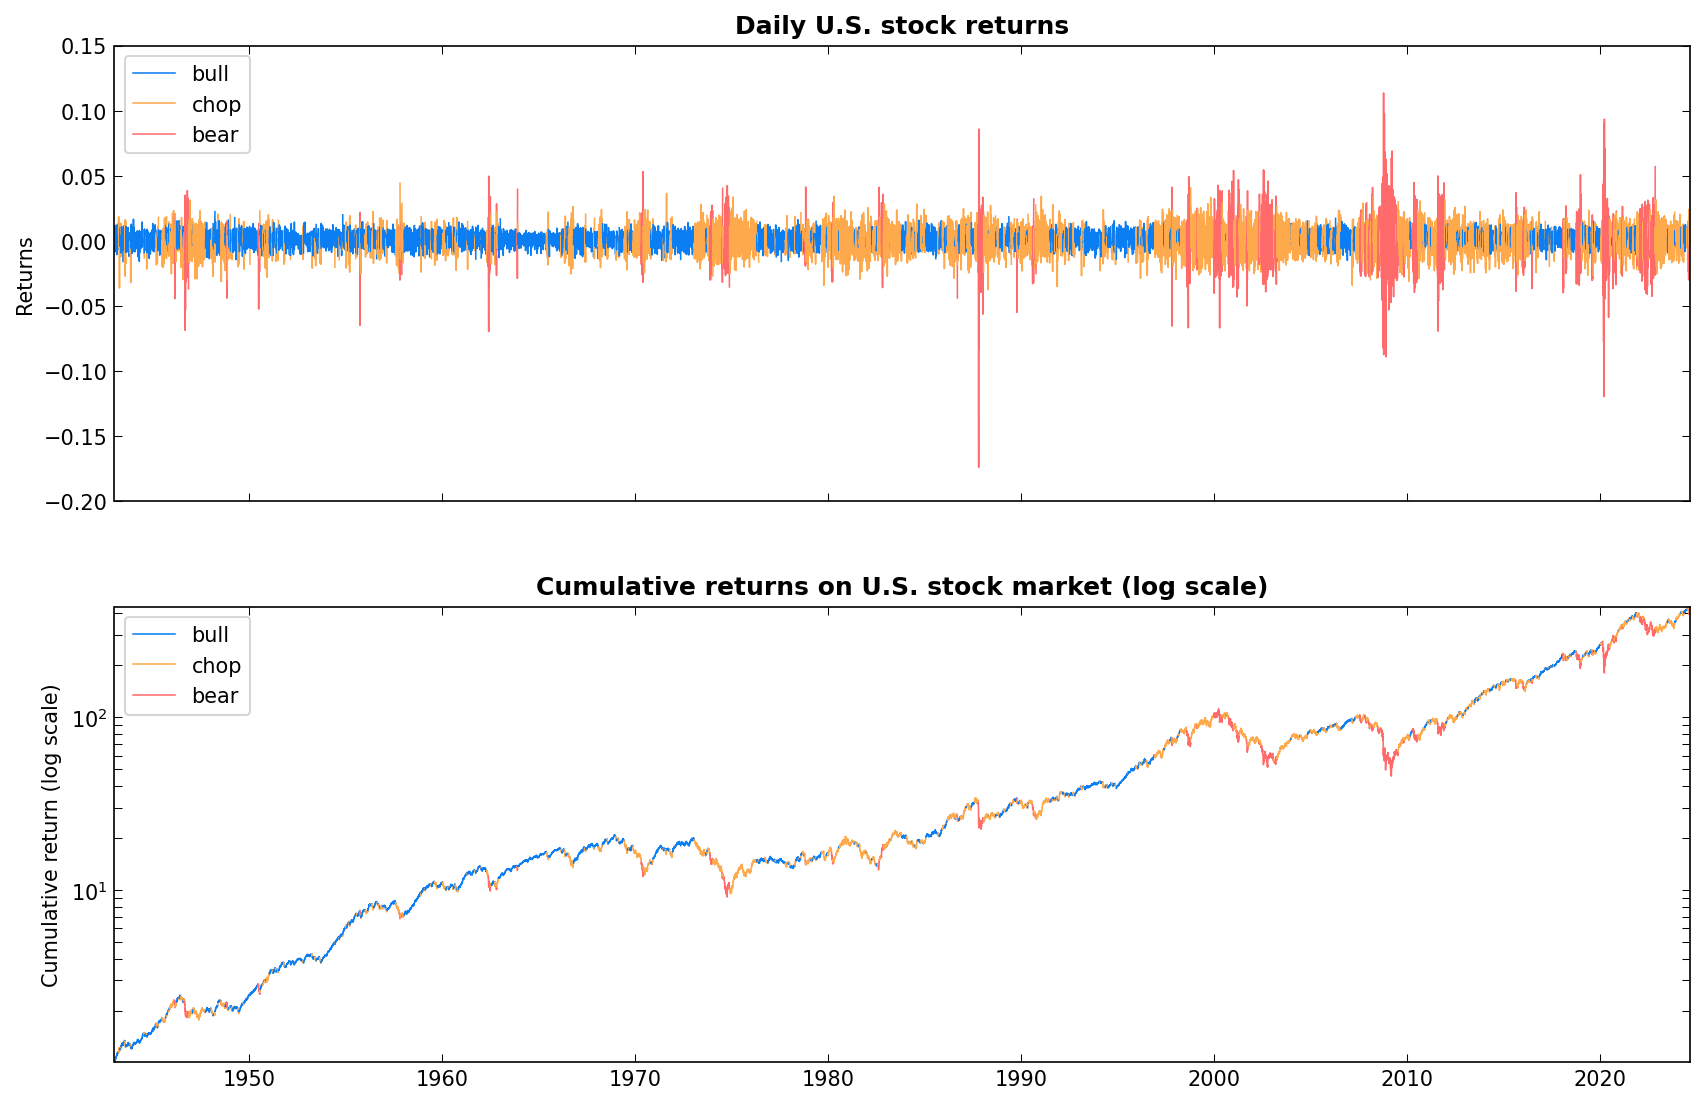

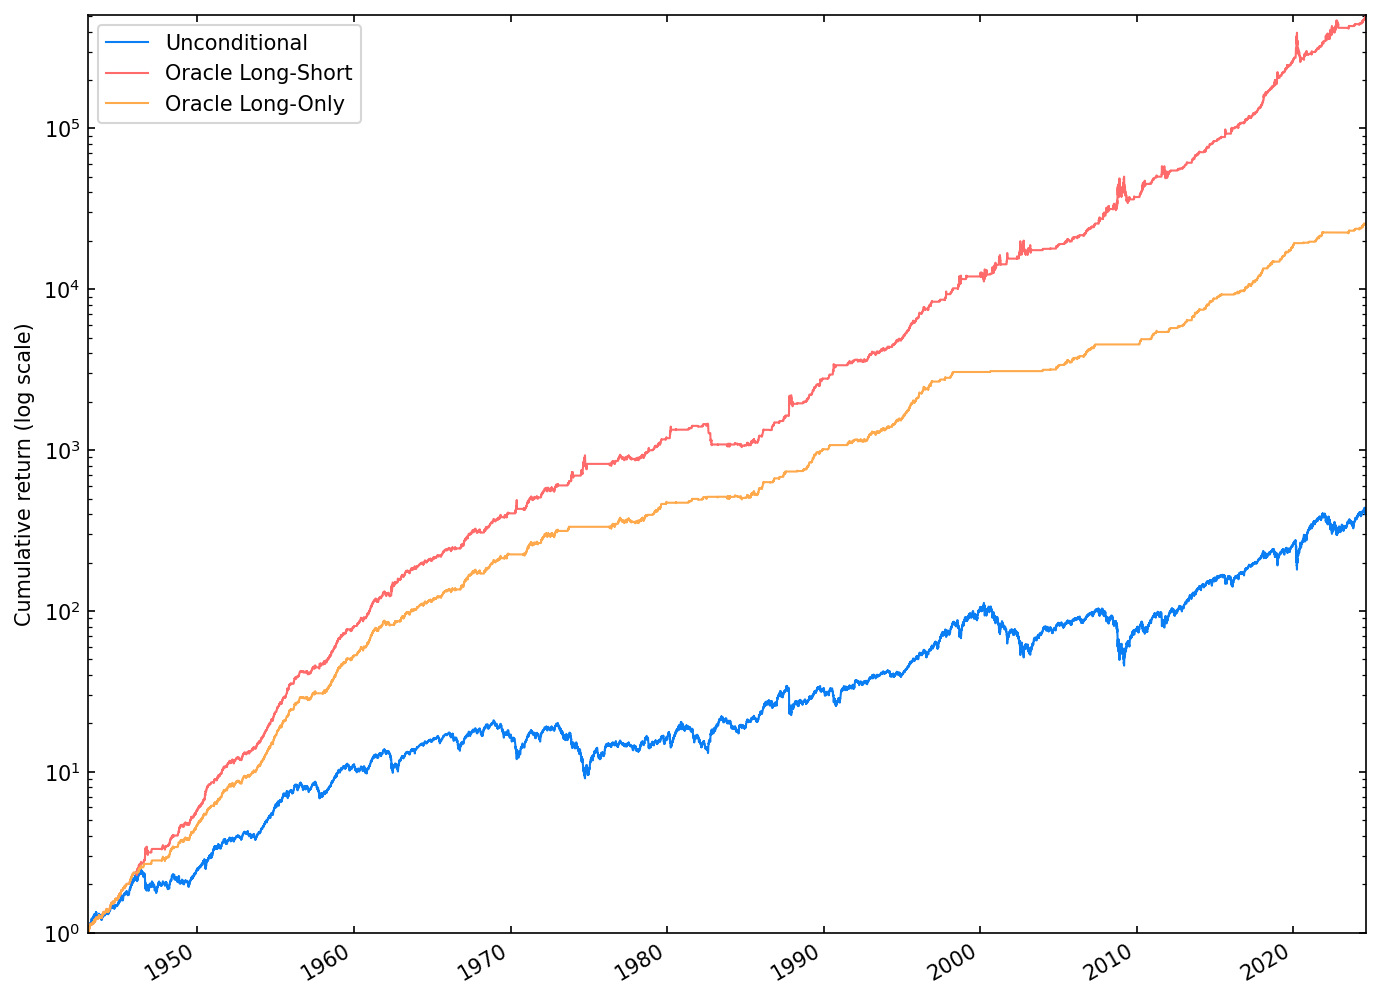

In [12]:
plot_return_and_cumulative_by_regime(
    state_assignments=active_regime,
    returns=returns_subsample,
    reg_ids=msm_classification.regime_map
)
cumulative_plot(strat_rets)

## 11. Compute Performance Metrics
Calculate daily metrics for each regime and oracle strategies.

In [13]:
cols = []
for k, r in msm_classification.regime_map.items():
    cols.append(returns_subsample.where(active_regime == k).rename(k))
regimes_returns = pd.concat(cols, axis=1)

reg_rets = pd.concat(
    [returns_subsample.iloc[2:], regimes_returns], 
    axis=1
).dropna(how='all')

In [14]:

compute_MSM_metrics_daily(reg_rets)

,Unconditional,bull,bear,chop
Annual excess return (%),8.44,26.34,-45.93,0.43
Volatility (%),15.02,7.35,34.36,14.48
Sharpe ratio,0.56,3.58,-1.34,0.03
% positive days,54.18,59.88,45.13,49.96
# of days,20886.00,9817.00,1879.00,9190.00
% of days,100.00,47.00,9.00,44.00
Max Drawdown (%),-59.28,-7.82,-98.06,-92.79


In [15]:
compute_MSM_metrics_daily(strat_rets.iloc[2:, [0, 2, 1]])

,Unconditional,Oracle Long-Only,Oracle Long-Short
Annual excess return (%),8.44,12.38,16.51
Volatility (%),15.02,5.11,11.51
Sharpe ratio,0.56,2.42,1.43
% positive days,54.18,28.14,33.06
# of days,20886.00,20886.00,20886.00
% of days,100.00,100.00,100.00
Max Drawdown (%),-59.28,-7.82,-34.30
